## The forward process

In [1]:
import math
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage


In [2]:
PATH = "/home/azureuser/Diffusion/"
IMAGE_PATH = PATH + "/data/images/0034309.jpg"

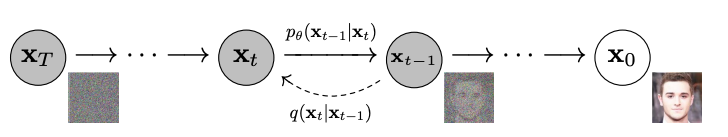

In [3]:
IPImage(filename= PATH + "display_images/Screenshot 2025-04-29 at 15.41.33.png") 

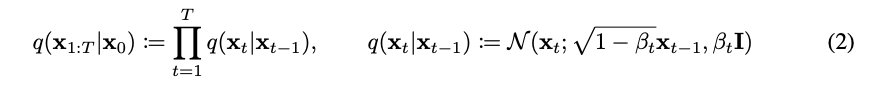

In [4]:
IPImage(filename=PATH + 'display_images/Screenshot 2025-04-29 at 15.44.16.png') 

Where the forward process (q) is a markov chain, in which xt depends only on xt-1 and randomly sampled guassian noise with mean and variance as above.

The original 2020 paper [https://arxiv.org/pdf/2006.11239] used a linear schedule, however here we will use a Cosine schedule.

In [5]:
def cosine_beta_schedule(T, s=0.008):
    """Creates the Cosine schedule from Nichol & Dhariwal (2021)
    ^^ this paper proves that its better than a linear schedule .
    [https://arxiv.org/pdf/2102.09672]
    """
    steps = torch.arange(T + 1, dtype=torch.float32) #1D tensor
    alphas_cumprod = torch.cos(
        (steps / T + s) / (1 + s) * math.pi * 0.5
    ) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(1e-8, 0.999) #clamps within a range

Why cosine schedule matters:
- Better than linear schedules: The cosine schedule was introduced by Nichol & Dhariwal (2021) [https://arxiv.org/pdf/2102.09672] as an improvement over linear schedules.

- Smoother transitions: It ensures smoother transitions in the noise levels, which helps:

- At early timesteps (small t): Adds very little noise (small betas)
- At middle timesteps: Gradually increases noise addition
- At late timesteps: Adds significant noise but avoids complete information destruction
- Improves sample quality: This schedule helps preserve important image features during the noising process, leading to better image generation during the reverse process.

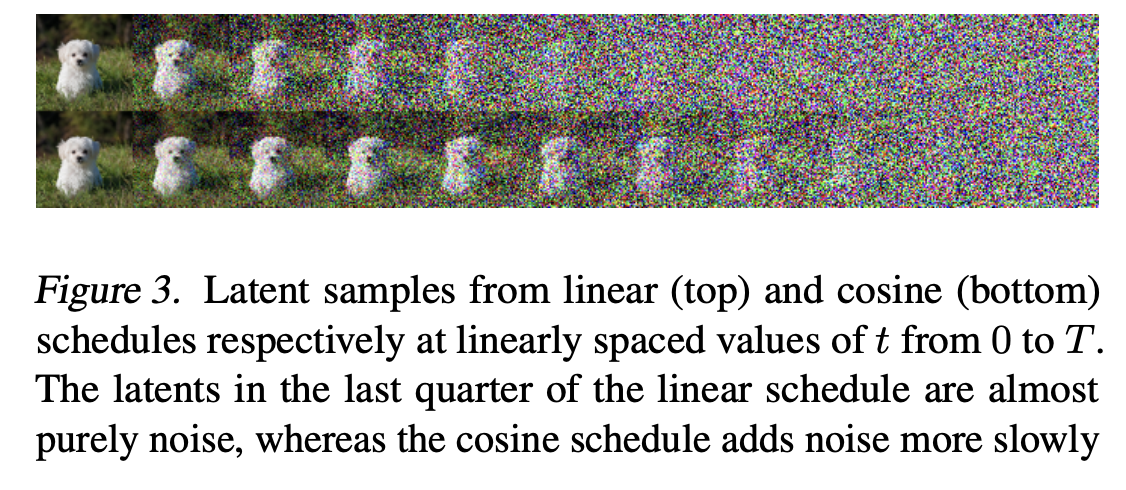

In [6]:
IPImage(filename=PATH + '/display_images/Screenshot 2025-04-30 at 10.32.23.png') 

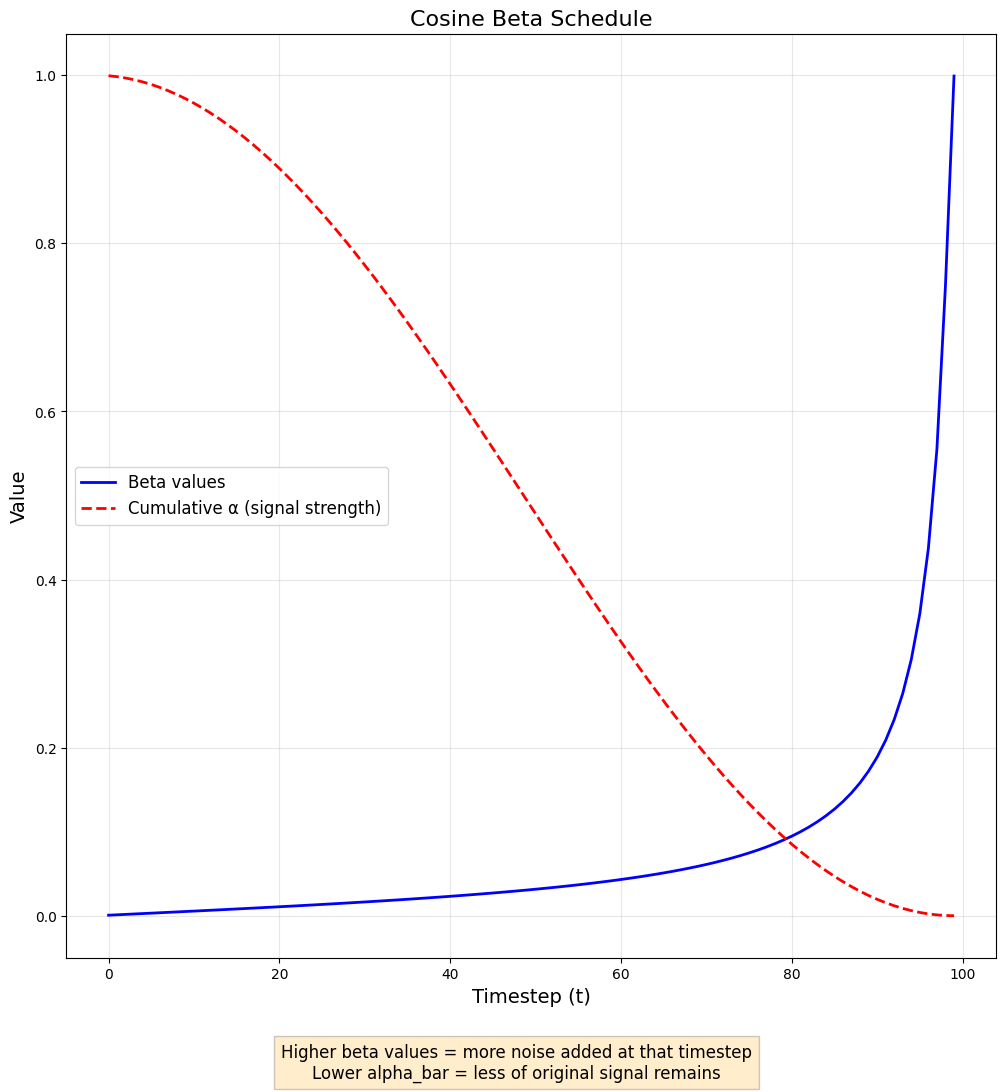

In [7]:
def plot_beta_schedule(T=1000, s=0.008, figsize=(12, 6)):
    """
    Plots the beta values from the cosine beta schedule.
    
    Args:
        T: Total number of diffusion steps
        s: Small offset parameter for the cosine schedule
        figsize: Size of the figure
    """
    betas = cosine_beta_schedule(T, s)
    
    timesteps = torch.arange(T) # creates a 1D tensor of timesteps from 0 to T-1
    
    plt.figure(figsize=figsize)
    
    plt.plot(timesteps.numpy(), betas.numpy(), 'b-', linewidth=2, label='Beta values')
    
    # Add a second plot showing cumulative product of (1-beta) values (how much of the original signal remains)
    alphas = 1.0 - betas
    alphas_bar = torch.cumprod(alphas, dim=0)
    plt.plot(timesteps.numpy(), alphas_bar.numpy(), 'r--', linewidth=2, label='Cumulative α (signal strength)')
    
    plt.xlabel('Timestep (t)', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.title('Cosine Beta Schedule', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.figtext(0.5, 0.01, 
               "Higher beta values = more noise added at that timestep\nLower alpha_bar = less of original signal remains", 
               ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.show()

plot_beta_schedule(T=100, s=0.008, figsize=(12, 12))

In [8]:
T = 1_000
betas = cosine_beta_schedule(T)
alphas_bar = torch.cumprod(1.0 - betas, dim=0)

In [9]:
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    return (alphas_bar[t].sqrt() * x0 +
            (1 - alphas_bar[t]).sqrt() * noise)

In [10]:
def load_image(path, size=256):
    img = Image.open(path).convert("RGB")
    img = TF.resize(img, size, Image.LANCZOS)
    x = TF.to_tensor(img) * 2.0 - 1.0              # [0,1] -> [-1,1]
    return x

def save_tensor(img_tensor, path):
    img = TF.to_pil_image((img_tensor.clamp(-1, 1) + 1) * 0.5)  # back to [0,1]
    img.save(path)

In [11]:
def display_noised_image(x0, t):
    """
    Displays the noised image at a given timestep.
    
    x0 : torch.Tensor, shape [3, H, W], values in [-1, 1]
    t  : integer timestep (0 ≤ t < T)
    """
    x_t = q_sample(x0, t)
    img = TF.to_pil_image((x_t.clamp(-1, 1) + 1) * 0.5)  # Convert back to [0, 1] range
    plt.imshow(img)
    plt.title(f"Noised Image at t={t}")
    plt.axis('off')
    plt.show()


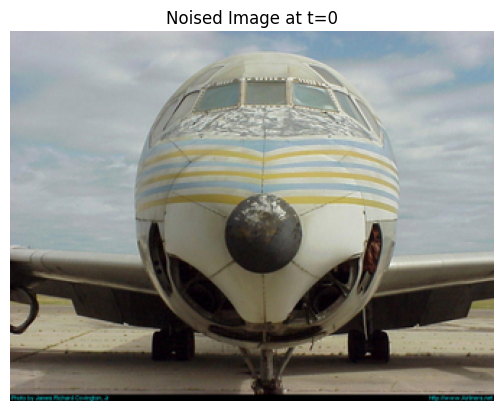

In [13]:
display_noised_image(load_image(IMAGE_PATH), 00)

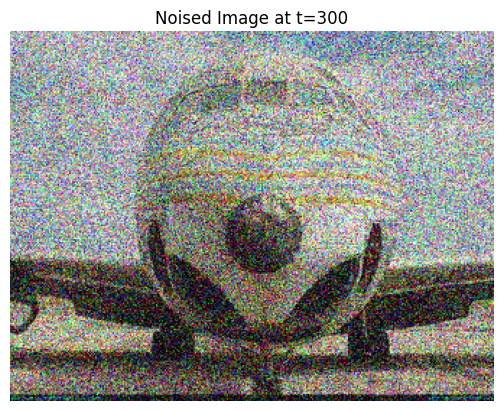

In [14]:
display_noised_image(load_image(IMAGE_PATH), 300)

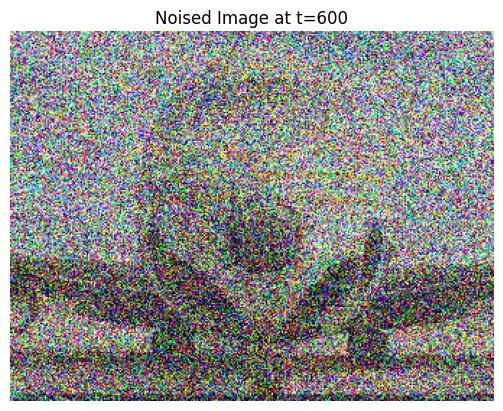

In [15]:
display_noised_image(load_image(IMAGE_PATH), 600)